In [166]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

### Read df from cleaned csv

In [167]:
df = pd.read_csv('../data/house_data_cleaned.csv')

In [168]:
df.head()

,Id,MSSubClass,MSZoning,Street,Alley,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,...,TotalBsmtSF,Heating,GrLivArea,KitchenQual,GarageType,GarageFinish,GarageCars,SalePrice,TotalSF,HasPool
0,1,60,RL,Pave,None,CollgCr,Norm,Norm,2Story,7,...,856,GasA,1710,Gd,Attchd,RFn,2,208500,2566,False
1,2,20,RL,Pave,None,Veenker,Feedr,Norm,1Story,6,...,1262,GasA,1262,TA,Attchd,RFn,2,181500,2524,False
2,3,60,RL,Pave,None,CollgCr,Norm,Norm,2Story,7,...,920,GasA,1786,Gd,Attchd,RFn,2,223500,2706,False
3,4,70,RL,Pave,None,Crawfor,Norm,Norm,2Story,7,...,756,GasA,1717,Gd,Detchd,Unf,3,140000,2473,False
4,5,60,RL,Pave,None,NoRidge,Norm,Norm,2Story,8,...,1145,GasA,2198,Gd,Attchd,RFn,3,250000,3343,False


### Figure 1 - Correlation of SalePrice to TotalsSF

In [1]:
model = sm.OLS(df['SalePrice'], sm.add_constant(df['TotalSF']))
p = model.fit().params
x = df['TotalSF']
ax = sns.scatterplot(x='TotalSF', y='SalePrice',data=df)
ax.plot(x, p.const + p['TotalSF'] * x)
print ("correlation :",scipy.stats.pearsonr(df['SalePrice'], df['TotalSF']))

NameError: name 'sm' is not defined

### Figure 2.1 - Correlation of SalePrice to TotalsSF w/ pools

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.16802605710441615, 0.7187596908749201)


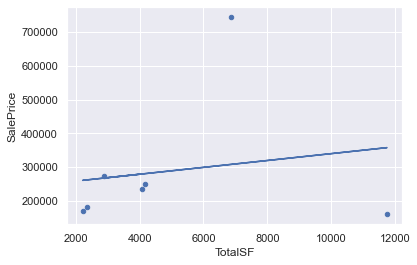

In [170]:
pool_model = sm.OLS(df[df['HasPool'] == True]['SalePrice'], sm.add_constant(df[df['HasPool'] == True]['TotalSF']))
pool_p = pool_model.fit().params
# generate x-values for your regression line (two is sufficient)
x = df[df['HasPool'] == True]['TotalSF']
# scatter-plot data
ax = df[df['HasPool'] == True].plot(x='TotalSF', y='SalePrice', kind='scatter')
# plot regression line on the same axes, set x-axis limits
ax.plot(x, pool_p.const + pool_p['TotalSF'] * x)
print ("correlation :",scipy.stats.pearsonr(df[df['HasPool'] == True]['SalePrice'], df[df['HasPool'] == True]['TotalSF']))

### Figure 2.2 - Correlation of SalePrice to TotalsSF w/o pools

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.7991861810882004, 5e-323)


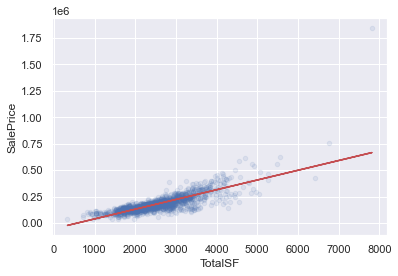

In [309]:
no_pool_model = sm.OLS(df[df['HasPool'] == False]['SalePrice'], sm.add_constant(df[df['HasPool'] == False]['TotalSF']))
no_pool_p = no_pool_model.fit().params
# generate x-values for your regression line (two is sufficient)
x = df[df['HasPool'] == False]['TotalSF']
# scatter-plot data
ax = df[df['HasPool'] == False].plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.1)
# plot regression line on the same axes, set x-axis limits
ax.plot(x, no_pool_p.const + no_pool_p['TotalSF'] * x, c='r')
print ("correlation :",scipy.stats.pearsonr(df[df['HasPool'] == False]['SalePrice'], df[df['HasPool'] == False]['TotalSF']))

### Figure 2.3 - Correlation of SalePrice to TotalsSF w/ pools after correcting outlier at index 1298

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Before update : 160000
After update : 1600000


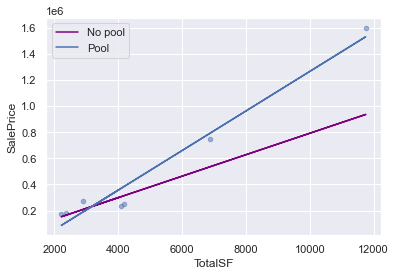

correlation w/ pools : (0.9809888892055241, 9.474037124304883e-05)


In [172]:
# One thing that stands out is how greatly the outliers affect the dataset that has a pool. So I will 
# re-run the regression, excluding those data points.
print('Before update : \033[1;48;34m' + str(df.iloc[1298]['SalePrice'])) 
# I have come to the conclusion that this outlier must be missing a zero on price. I say this because the
# indicators I have found to have strong correlations with price, for instance Area is very high, and the 
# Quality measures such as kitchen quality and Overall Style, are maximum values. The only value that
# doesn't fit the data is the sale price. So I will update it to $1.6 million.
df.at[1298,'SalePrice'] = 1600000
print('\033[mAfter update : \033[1;48;34m' + str(df.iloc[1298]['SalePrice']))
# Now to run it again.
pool_model = sm.OLS(df[df['HasPool'] == True]['SalePrice'], 
    sm.add_constant(df[df['HasPool'] == True]['TotalSF']))
pool_p = pool_model.fit().params
# generate x-values for your regression line (two is sufficient)
x = df[df['HasPool'] == True]['TotalSF']
# scatter-plot data
ax = df[df['HasPool'] == True].plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.5)
# plot regression line on the same axes, set x-axis limits
line1, = ax.plot(x, no_pool_p.const + no_pool_p['TotalSF'] * x, c='purple')
line2, = ax.plot(x, pool_p.const + pool_p['TotalSF'] * x)
ax.legend([line1, line2],['No pool','Pool'])
plt.show()
print ("\033[mcorrelation w/ pools :\033[1;48;34m",scipy.stats.pearsonr(df[df['HasPool'] == True]['SalePrice'], \
    df[df['HasPool'] == True]['TotalSF']))

### Figure 2.4 - Correlation of SalePrice to TotalsSF w/o pools after correcting outlier at index 1298

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


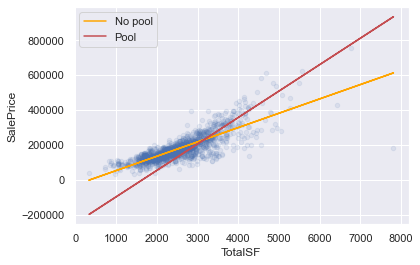

correlation with pool: (0.9809888892055241, 9.474037124304883e-05)
correlation without pool: (0.8166448166913953, 0.0)


In [173]:
no_pool_model = sm.OLS(df[df['HasPool'] == False]['SalePrice'], sm.add_constant(df[df['HasPool'] == False]['TotalSF']))
no_pool_p = no_pool_model.fit().params
x = df[df['HasPool'] == False]['TotalSF']
ax = df[df['HasPool'] == False].plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.1)
line1, = ax.plot(x, no_pool_p.const + no_pool_p['TotalSF'] * x, c='orange')
line2, = ax.plot(x, pool_p.const + pool_p['TotalSF'] * x, c='r')
ax.legend([line1, line2],['No pool','Pool'])
plt.show()
print ("correlation with pool:",scipy.stats.pearsonr(df[df['HasPool'] == True]['SalePrice'], df[df['HasPool'] == True]['TotalSF']))
print ("correlation without pool:",scipy.stats.pearsonr(df[df['HasPool'] == False]['SalePrice'], df[df['HasPool'] == False]['TotalSF']))

### Explore neighborhood statistics, particularly how Edwards neighborhoods compares to the others.
###### Note that the correlation for homes with pools more closely matches after increasing the sale price of our outlier by a factor of 10.

In [174]:
nb_mean_dict = {}
print('Mean\n')
for nb in df['Neighborhood']:    
    nb_mean_dict[nb]= df[df['Neighborhood'] == nb]['SalePrice'].mean()
for idx, x in enumerate(sorted(nb_mean_dict.items(), key=lambda item: -item[1])):
    print(str(idx + 1) + '. ' + str(x[0]) +' - $ ' + '{:,.0f}'.format(x[1]) if \
          x[0] != 'Edwards' else str(idx + 1) + '. ' + '\033[1;48;34m' + str(x[0]) + \
          ' - $ ' + '{:,.0f}'.format(x[1]) + '\033[m')
print('\nMedian\n')
nb_median_dict = {}
for nb in df['Neighborhood']:    
    nb_median_dict[nb]= df[df['Neighborhood'] == nb]['SalePrice'].median()

for idx, x in enumerate(sorted(nb_median_dict.items(), key=lambda item: -item[1])):
    print(str(idx + 1) + '. ' + str(x[0]) +' - $ ' + '{:,.0f}'.format(x[1]) if \
          x[0] != 'Edwards' else str(idx + 1) + '. ' + '\033[1;48;34m' + str(x[0]) + \
          ' - $ ' + '{:,.0f}'.format(x[1]) + '\033[m')
print('\nMinimum\n')
nb_min_dict = {}
for nb in df['Neighborhood']:    
    nb_min_dict[nb]= df[df['Neighborhood'] == nb]['SalePrice'].min()
for idx, x in enumerate(sorted(nb_min_dict.items(), key=lambda item: -item[1])):
    print(str(idx + 1) + '. ' + str(x[0]) +' - $ ' + '{:,.0f}'.format(x[1]) if \
          x[0] != 'Edwards' else str(idx + 1) + '. ' + '\033[1;48;34m' + str(x[0]) + \
          ' - $ ' + '{:,.0f}'.format(x[1]) + '\033[m')
print('\nMaximum\n')
nb_max_dict = {}
for nb in df['Neighborhood']:    
    nb_max_dict[nb]= df[df['Neighborhood'] == nb]['SalePrice'].max()

for idx, x in enumerate(sorted(nb_max_dict.items(), key=lambda item: -item[1])):
    print(str(idx + 1) + '. ' + str(x[0]) +' - $ ' + '{:,.0f}'.format(x[1]) if \
          x[0] != 'Edwards' else str(idx + 1) + '. ' + '\033[1;48;34m' + str(x[0]) + \
          ' - $ ' + '{:,.0f}'.format(x[1]) + '\033[m')

Mean

1. NoRidge - $ 335,295
2. NridgHt - $ 316,271
3. StoneBr - $ 310,499
4. Timber - $ 242,247
5. Veenker - $ 238,773
6. Somerst - $ 225,380
7. ClearCr - $ 212,565
8. Crawfor - $ 210,625
9. CollgCr - $ 197,966
10. Blmngtn - $ 194,871
11. Gilbert - $ 192,855
12. NWAmes - $ 189,050
13. SawyerW - $ 186,556
14. Mitchel - $ 156,270
15. NAmes - $ 145,847
16. NPkVill - $ 142,694
17. Edwards - $ 142,620
18. SWISU - $ 142,591
19. Blueste - $ 137,500
20. Sawyer - $ 136,793
21. OldTown - $ 128,225
22. BrkSide - $ 124,834
23. BrDale - $ 104,494
24. IDOTRR - $ 100,124
25. MeadowV - $ 98,576

Median

1. NridgHt - $ 315,000
2. NoRidge - $ 301,500
3. StoneBr - $ 278,000
4. Timber - $ 228,475
5. Somerst - $ 225,500
6. Veenker - $ 218,000
7. Crawfor - $ 200,624
8. ClearCr - $ 200,250
9. CollgCr - $ 197,200
10. Blmngtn - $ 191,000
11. NWAmes - $ 182,900
12. Gilbert - $ 181,000
13. SawyerW - $ 179,900
14. Mitchel - $ 153,500
15. NPkVill - $ 146,000
16. NAmes - $ 140,000
17. SWISU - $ 139,500
18. Blueste

In [175]:
# There is another outlier that I believe is also an inaccuracy. The neighborhood is the same as the 
# outlier I previously revealed. The neighborhood is relatively inexpensive. It's also in the Edwards 
# neighborhood, which stands out from others.
print(df[df['TotalSF'] > 7000])
print(df.iloc[523])
print(df.iloc[1298])

        Id  MSSubClass MSZoning Street Alley Neighborhood Condition1  \
523    524          60       RL   Pave  None      Edwards       PosN   
1298  1299          60       RL   Pave  None      Edwards      Feedr   

     Condition2 HouseStyle  OverallQual  ... TotalBsmtSF  Heating GrLivArea  \
523        PosN     2Story           10  ...        3138     GasA      4676   
1298       Norm     2Story           10  ...        6110     GasA      5642   

     KitchenQual  GarageType GarageFinish  GarageCars SalePrice TotalSF  \
523           Ex     BuiltIn          Fin           3    184750    7814   
1298          Ex      Attchd          Fin           2   1600000   11752   

     HasPool  
523    False  
1298    True  

[2 rows x 24 columns]
Id                  524
MSSubClass           60
MSZoning             RL
Street             Pave
Alley              None
Neighborhood    Edwards
Condition1         PosN
Condition2         PosN
HouseStyle       2Story
OverallQual          10
MasVnrType 

In [176]:
# I want to compare these locations further with the data from the original df.
orig_df = pd.read_csv('../train.csv')
print(orig_df.iloc[[523,1298]].select_dtypes('int64'))

        Id  MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  \
523    524          60    40094           10            5       2007   
1298  1299          60    63887           10            5       2008   

      YearRemodAdd  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  WoodDeckSF  \
523           2008        2260           0        878  ...         208   
1298          2008        5644           0        466  ...         214   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
523           406              0          0            0         0        0   
1298          292              0          0            0       480        0   

      MoSold  YrSold  SalePrice  
523       10    2007     184750  
1298       1    2008     160000  

[2 rows x 35 columns]


### Figure 3 - Correlation of LotArea to SalePrice

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.2638433538714057, 1.1231391549193063e-24)


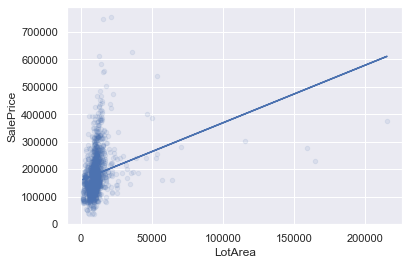

In [177]:
model = sm.OLS(orig_df['SalePrice'], sm.add_constant(orig_df['LotArea']))
p = model.fit().params
# generate x-values for your regression line (two is sufficient)
x = orig_df['LotArea']
# scatter-plot data
ax = orig_df.plot(x='LotArea', y='SalePrice', kind='scatter', alpha = 0.1)
# plot regression line on the same axes, set x-axis limits
ax.plot(x, p.const + p['LotArea'] * x)
print ("correlation :",scipy.stats.pearsonr(orig_df['SalePrice'], orig_df['LotArea']))

In [178]:
# These two homes are very large, on large plots of land, and brand new, so I believe that 
# the value is once again low by a factor of 10.
df.at[523,'SalePrice'] = 10 * df.iloc[523]['SalePrice']

In [179]:
# Looking back on the original df at the correlation of sale price and lot area, there is a decent
# correlation. Now we will examine all values with large LotArea's defined as greater than 40,000.
orig_df = pd.read_csv('../train.csv')
# --- Uncomment below to examine the resulting df for yourself.
# --- print(orig_df[orig_df['LotArea'] > 40000].select_dtypes('int64'))
print(df.iloc[[523,769,1298]].select_dtypes('int64'))
'{:,.0f}'.format(orig_df.LotArea.mean())

        Id  MSSubClass  OverallQual  TotalBsmtSF  GrLivArea  GarageCars  \
523    524          60           10         3138       4676           3   
769    770          60            8         1650       3279           3   
1298  1299          60           10         6110       5642           2   

      SalePrice  TotalSF  
523     1847500     7814  
769      538000     4929  
1298    1600000    11752  


'10,517'

### Figure 4 - Correlation of SalePrice and TotalSF among 3 outliers within LotArea

correlation : (0.7029210741162513, 0.5037573939582445)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


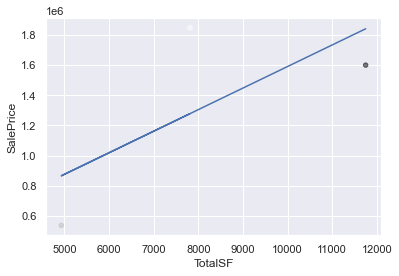

In [180]:
# An interesting find was a home with a much larger lot area, but only about a third of the price of our 
# other two extreme values.
model = sm.OLS(df.iloc[[523,769,1298]]['SalePrice'], sm.add_constant(df.iloc[[523,769,1298]]['TotalSF']))
p = model.fit().params
x = df.iloc[[523,769,1298]]['TotalSF']
ax = df.iloc[[523,769,1298]].plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.5)
ax.plot(x, p.const + p['TotalSF'] * x)
print ("correlation :",scipy.stats.pearsonr(df.iloc[[523,769,1298]]['SalePrice'], df.iloc[[523,769,1298]]['TotalSF']))

In [181]:
# The above isn't technically a statistically significant result, however, it is largely 
# inline with our correlation of SalePrice to TotalSF overall. 
orig_df[orig_df['Neighborhood'] == 'Edwards'].groupby('SaleCondition').SalePrice.count()

SaleCondition
Abnorml     8
AdjLand     4
Alloca      2
Normal     82
Partial     4
Name: SalePrice, dtype: int64

### Figure 5 - Correlation of SalePrice and TotalSF after outlier SalePrice 
#### updated values increased by a factor of 10

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.8215488105837597, 0.0)


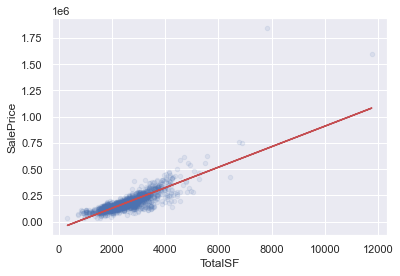

In [182]:
# These two changes showed an increase on the correlation coefficient of SalePrice and TotalSF.
model = sm.OLS(df['SalePrice'], sm.add_constant(df['TotalSF']))
p = model.fit().params
# generate x-values for your regression line (two is sufficient)
x = df['TotalSF']
# scatter-plot data
ax = df.plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.1)
# plot regression line on the same axes, set x-axis limits
ax.plot(x, p.const + p['TotalSF'] * x, c='r')
print ("correlation :",scipy.stats.pearsonr(df['SalePrice'], df['TotalSF']))

In [183]:
# The two outliers make more sense, in terms of the dataset now, thought they skew the data significantly.
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'Neighborhood',
       'Condition1', 'Condition2', 'HouseStyle', 'OverallQual', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'TotalBsmtSF', 'Heating',
       'GrLivArea', 'KitchenQual', 'GarageType', 'GarageFinish', 'GarageCars',
       'SalePrice', 'TotalSF', 'HasPool'],
      dtype='object')

### Examine all 3-dimensional correlations between all numeric columns and SalePrice and TotalSF

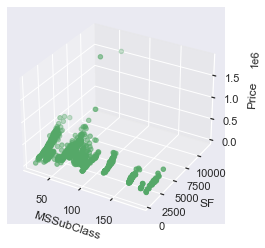

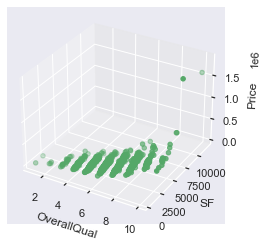

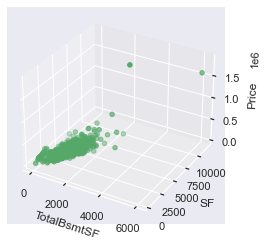

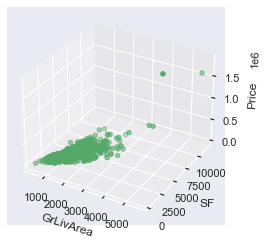

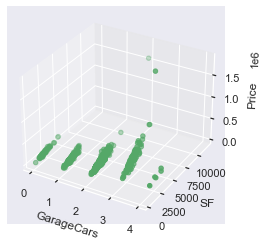

In [184]:
for col in df.select_dtypes('int64').drop(columns=['Id','TotalSF','SalePrice']).columns:    
    sns.set(style = "darkgrid")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    x = df[col]
    y = df['TotalSF']
    z = df['SalePrice']

    ax.set_xlabel(col)
    ax.set_ylabel("SF")
    ax.set_zlabel("Price")

    ax.scatter(x, y, z, c='g')

    plt.show()

In [185]:
# Another thing that stands out to me is the correlation of GarageCars and SF and Price, except for 4. So I
# am going to combine 4 into the column 3.
df['GarageCars'].replace(to_replace=4, value=3, inplace=True)
df['GarageCars'].unique()

array([2, 3, 1, 0])

### Figure 6 - Correlation of GarageCars, TotalSF and SalePrice

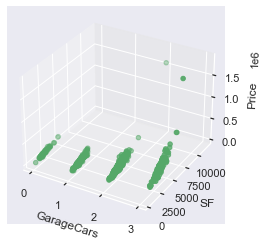

In [186]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['GarageCars']
y = df['TotalSF']
z = df['SalePrice']

ax.set_xlabel('GarageCars')
ax.set_ylabel("SF")
ax.set_zlabel("Price")

ax.scatter(x, y, z, c='g')

plt.show()

### Correlations of SalePrice and TotalSf by OverallQual

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence i

7  correlation :  (0.718861814857261, 5.40313031836748e-52)
6  correlation :  (0.6909666311094307, 2.2375603137511756e-54)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

8  correlation :  (0.7143956903286686, 1.5650935210041917e-27)
5  correlation :  (0.563663159577783, 1.1432288863414272e-34)
9  correlation :  (0.8043526145388762, 8.164069368827626e-11)
4  correlation :  (0.6213515054855221, 9.905970022926983e-14)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


10  correlation :  (0.8689793140593526, 2.8715070249070093e-06)
3  correlation :  (0.37330534506541835, 0.10497238735747137)
1  correlation :  (1.0, 1.0)
2  correlation :  (-0.21480864541642186, 0.8621744311325219)


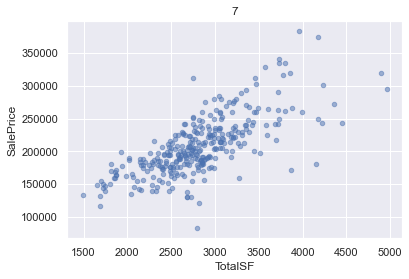

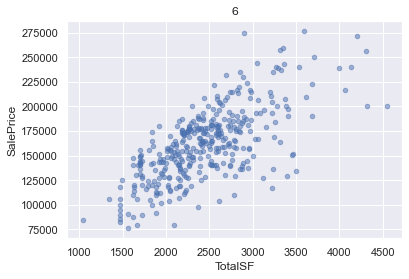

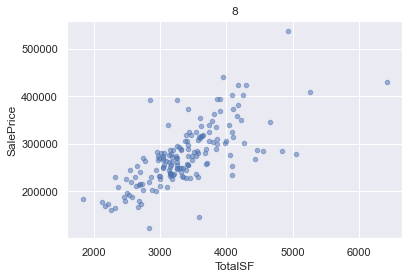

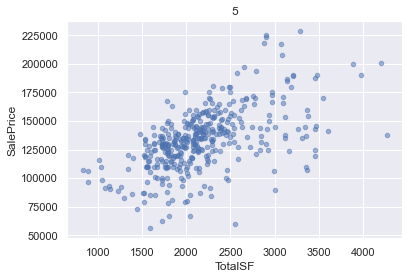

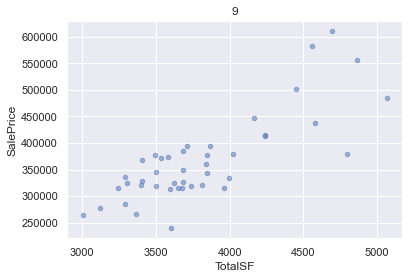

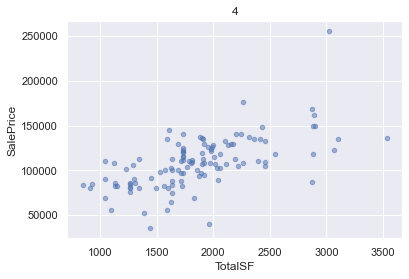

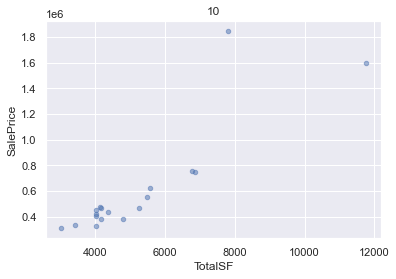

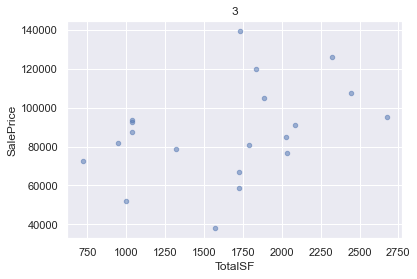

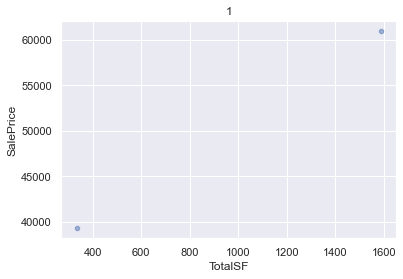

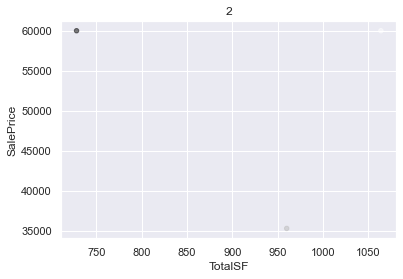

In [187]:
# One observation I've made is that each variable is pretty strongly correlated for lower values, 
# but I believe this will be explained in some of the qualitative variables.
for value in df.OverallQual.unique():
    col_model = sm.OLS(df[df['OverallQual'] == value]['SalePrice'], sm.add_constant(df[df['OverallQual'] == value]['TotalSF']))
    col_p = col_model.fit().params
    x = df[df['OverallQual'] == value]['TotalSF']
    ax = df[df['OverallQual'] == value].plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.5, title=value)
    corrcoef = scipy.stats.pearsonr(df[df['OverallQual'] == value]['SalePrice'], df[df['OverallQual'] == value]['TotalSF'])
    if(np.abs(corrcoef[0]) > .2):
        print(value, " correlation : ",corrcoef)

In [188]:
# Overall Condition values over above three yeild strong correlations between SalePrice and TotalSF. 
print(df[(df['SalePrice'] > 35000) & (df['SalePrice'] < 61000) & (df['TotalSF'] > 700) & (df['TotalSF'] < 1000)])

        Id  MSSubClass MSZoning Street Alley Neighborhood Condition1  \
710    711          30       RL   Pave  None      BrkSide       Norm   
916    917          20  C (all)   Pave  None       IDOTRR       Norm   
1100  1101          30       RL   Pave  None        SWISU       Norm   

     Condition2 HouseStyle  OverallQual  ... TotalBsmtSF  Heating GrLivArea  \
710        Norm     1Story            3  ...         270     GasA       729   
916        Norm     1Story            2  ...         480     GasA       480   
1100       Norm     1Story            2  ...         290     GasA       438   

     KitchenQual  GarageType GarageFinish  GarageCars SalePrice TotalSF  \
710           TA        None         None           0     52000     999   
916           TA      Detchd          Unf           1     35311     960   
1100          Fa      Detchd          Unf           1     60000     728   

     HasPool  
710    False  
916    False  
1100   False  

[3 rows x 24 columns]


### Figure 7 - Correlation of TotalSF and SalePrice, 
#### restricted to SalePrice under $100,000 and TotalSF under 1400

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.3613311656220852, 0.023817542914674514)


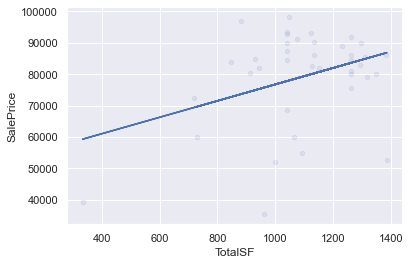

In [189]:
# What I see above is that the first value, with id 711, Each of them seems to correlate roughly 
# between neighborhood mean values to sale price. IDOTRR is the cheapest average price of the 3, 
# and the home in that neighborhood is also the cheapest, and SWISU is the most expensive of the
# 3 on average, and the home in SWISU is the most expensive, despite being the smallest. I believe
# the appearance of these values as outliers is explained by the neighborhoods they are in, and 
# therefore they fit the dataset fairly well overall.
restricted_df = df[(df['SalePrice'] < 100000) & (df['TotalSF'] < 1400)]
model = sm.OLS(restricted_df['SalePrice'], sm.add_constant(restricted_df['TotalSF']))
p = model.fit().params
# generate x-values for your regression line (two is sufficient)
x = restricted_df['TotalSF']
# scatter-plot data
ax = restricted_df.plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.1)
# plot regression line on the same axes, set x-axis limits
ax.plot(x, p.const + p['TotalSF'] * x)
print ("correlation :",scipy.stats.pearsonr(restricted_df['SalePrice'], restricted_df['TotalSF']))

##### As we see above, the restricted correlation is not strong, nor as statistically significant, as the 
##### dataset as a whole.

### Figure 8 - Correlation of TotalSF and SalePrice, restricted to those homes under $300,000

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.7693090926839589, 3.282034835819395e-263)


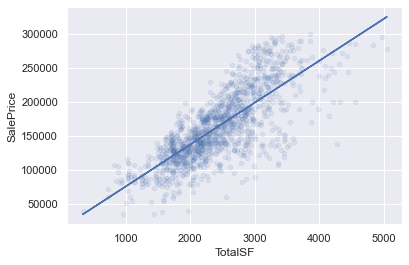

In [190]:
restricted_df = df[df['SalePrice'] < 300000]
model = sm.OLS(restricted_df['SalePrice'], sm.add_constant(restricted_df['TotalSF']))
p = model.fit().params
x = restricted_df['TotalSF']
ax = restricted_df.plot(x='TotalSF', y='SalePrice', kind='scatter', alpha = 0.1)
ax.plot(x, p.const + p['TotalSF'] * x)
print ("correlation :",scipy.stats.pearsonr(restricted_df['SalePrice'], restricted_df['TotalSF']))

### Scatterplots to examine the correlation of TotalSF and SalePrice

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

Blmngtn  correlation :  (0.6129754089287498, 0.008886716763331132)
Blueste  correlation :  (1.0, 1.0)
BrDale  correlation :  (0.6807692452276011, 0.0036974586923680976)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

BrkSide  correlation :  (0.8638220838566508, 2.5898991828566336e-18)
ClearCr  correlation :  (0.5524069807505488, 0.0023029114829260532)
CollgCr  correlation :  (0.8893237924552659, 3.740611053320732e-52)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

Crawfor  correlation :  (0.7334666121371041, 9.258704026777114e-10)
Edwards  correlation :  (0.8844918359859018, 3.2349320319283905e-34)
Gilbert  correlation :  (0.764510406809342, 2.4323091066126087e-16)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

IDOTRR  correlation :  (0.6482105877446923, 1.4380953353038984e-05)
MeadowV  correlation :  (0.8664834517621864, 6.838369602087765e-06)
Mitchel  correlation :  (0.7035829046435447, 1.7155327101432072e-08)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

NAmes  correlation :  (0.7021845445384407, 9.577320071377748e-35)
NPkVill  correlation :  (0.5980573347140649, 0.08892555292997843)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

NWAmes  correlation :  (0.6915455414832496, 1.2561560246716434e-11)
NoRidge  correlation :  (0.8963922170689058, 2.335189074696072e-15)
NridgHt  correlation :  (0.8539935280001443, 5.590488329001563e-23)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

OldTown  correlation :  (0.6829829400041416, 7.890581164179535e-17)
SWISU  correlation :  (0.7583136237265367, 1.1231832945986113e-05)
Sawyer  correlation :  (0.5423918764936194, 5.985817013981369e-07)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/p

SawyerW  correlation :  (0.9177475258372716, 1.5823696718461987e-24)
Somerst  correlation :  (0.8423884033748057, 2.8553908199165774e-24)


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-arg

StoneBr  correlation :  (0.9151638519374856, 1.4982867976915876e-10)
Timber  correlation :  (0.8054439160830154, 1.0716766360356067e-09)
Veenker  correlation :  (0.9369196402853521, 2.1244359686394447e-05)


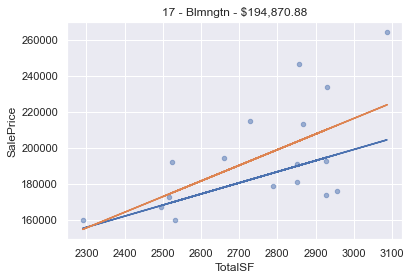

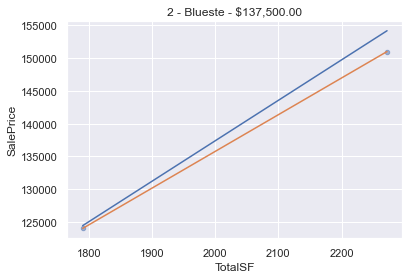

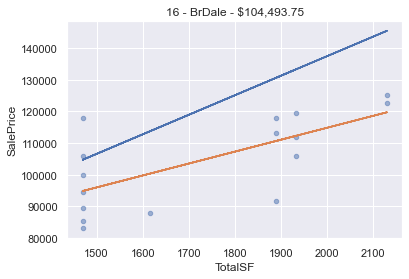

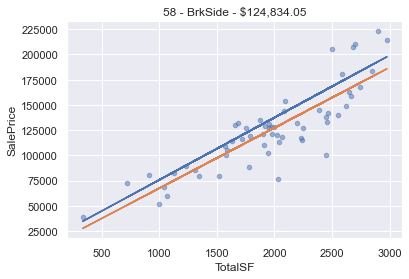

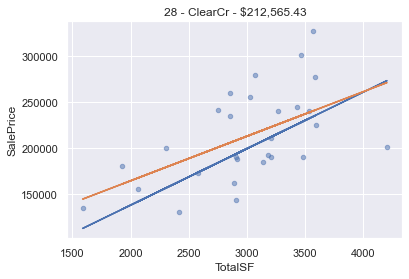

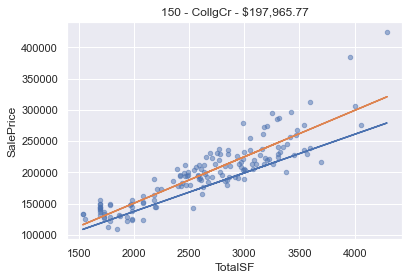

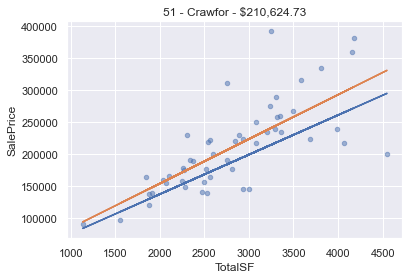

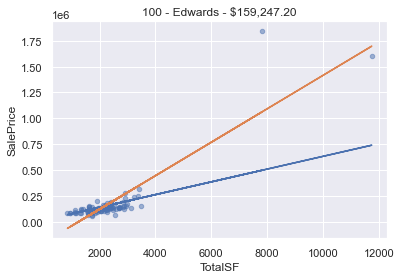

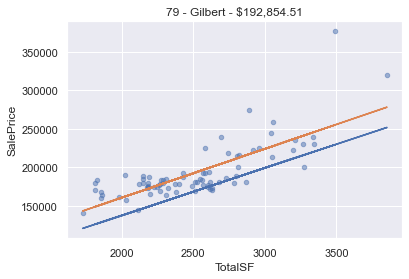

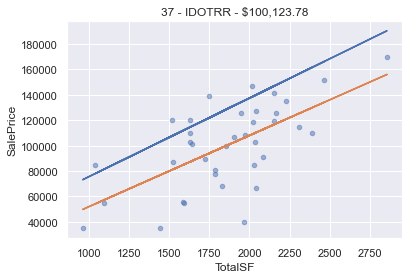

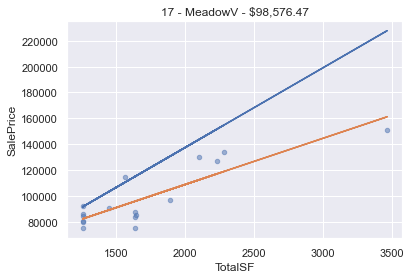

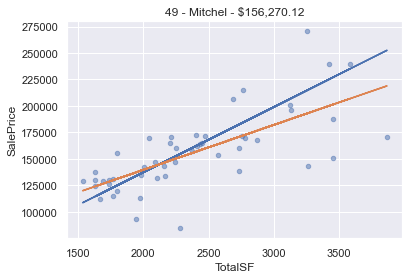

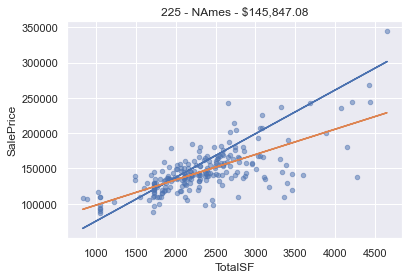

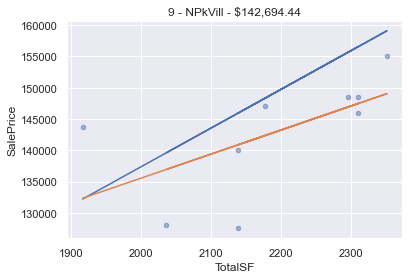

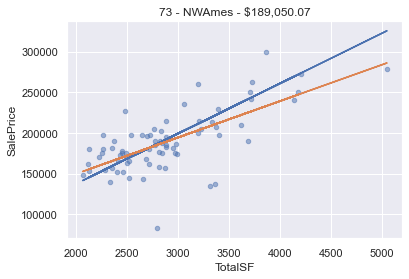

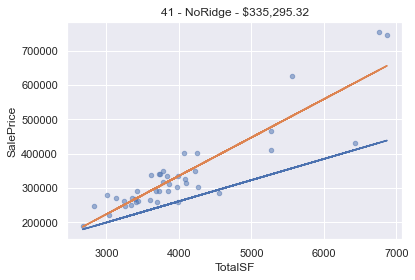

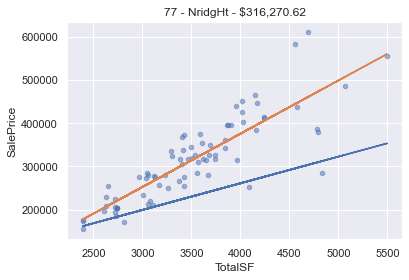

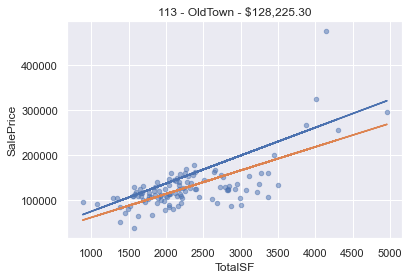

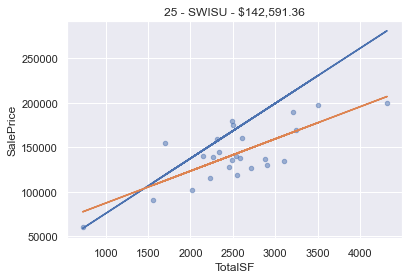

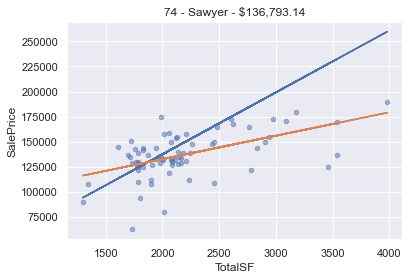

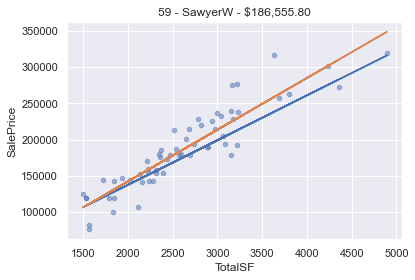

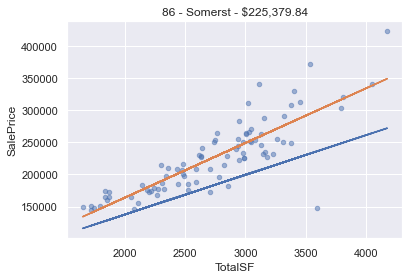

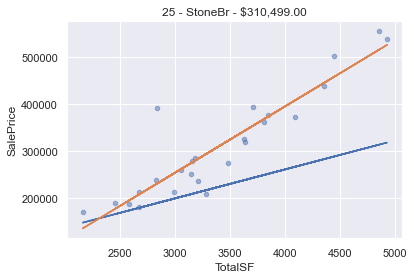

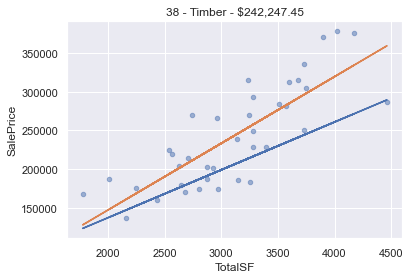

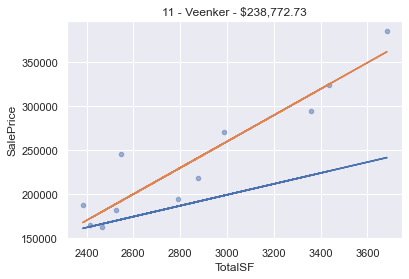

In [191]:
# The correlation seems to be more quadratic than linear, which seems to suggest that neighborhood, as
# seen above, plays a role in both total sf and sale price, which I now hypothesize causes this affect.
# I will now loop over neighborhoods to view the correlation of area and sale price.
for value in sorted(df.Neighborhood.unique()):
    col_model = sm.OLS(df[df['Neighborhood'] == value]['SalePrice'], sm.add_constant(df[df['Neighborhood'] == value]['TotalSF']))
    col_p = col_model.fit().params
    x = df[df['Neighborhood'] == value]['TotalSF']
    ax = df[df['Neighborhood'] == value].plot(x='TotalSF', \
        y='SalePrice', kind='scatter', alpha = 0.5, \
        title= str(df[df['Neighborhood'] == value]['Id'].count()) \
        + ' - ' + value + ' - ${:,.2f}'.format(df[df['Neighborhood'] \
        == value]['SalePrice'].mean()))
    ax.plot(x, p.const + p['TotalSF'] * x)
    ax.plot(x, col_p.const + col_p['TotalSF'] * x)
    corrcoef = scipy.stats.pearsonr(df[df['Neighborhood'] == value]['SalePrice'], df[df['Neighborhood'] == value]['TotalSF'])
    if(np.abs(corrcoef[0]) > .2):
        print(value, " correlation : ",corrcoef)

### Figure 9.1 - Correlation of YearBuilt and SalePrice on the original dataset

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


-2530308.245732358
correlation : (0.5228973328794969, 2.9902290990158995e-103)


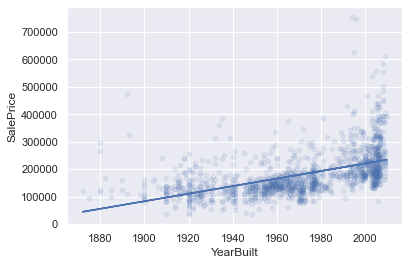

In [192]:
# I'd like to look more into my two major outliers in Edwards neighborhood, which I adjusted their
# values by a factor of 10. They were both newly built homes, of high quality, and very large size.
restricted_df = orig_df
model = sm.OLS(restricted_df['SalePrice'], sm.add_constant(restricted_df['YearBuilt']))
p = model.fit().params
x = restricted_df['YearBuilt']
ax = restricted_df.plot(x='YearBuilt', y='SalePrice', kind='scatter', alpha = 0.1)
ax.plot(x, p.const + p['YearBuilt'] * x)
print(p.const)
print ("correlation :",scipy.stats.pearsonr(restricted_df['SalePrice'], restricted_df['YearBuilt']))

### Figure 9.2 - Correlation of TotalSF and YearBuilt

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


correlation : (0.34713269256611656, 1.333148662766363e-42)


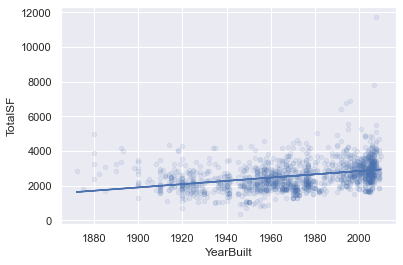

In [193]:
df['YearBuilt'] = orig_df['YearBuilt']
restricted_df = df
model = sm.OLS(restricted_df['TotalSF'], sm.add_constant(restricted_df['YearBuilt']))
p = model.fit().params
x = restricted_df['YearBuilt']
ax = restricted_df.plot(x='YearBuilt', y='TotalSF', kind='scatter', alpha = 0.1)
ax.plot(x, p.const + p['YearBuilt'] * x)
print ("correlation :",scipy.stats.pearsonr(restricted_df['TotalSF'], restricted_df['YearBuilt']))

### Figure 9.3 - Correlation of SalePrice and YearBuilt on updated dataset

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


-2694525.8141156556
correlation : (0.4502098133812418, 8.955559672733592e-74)


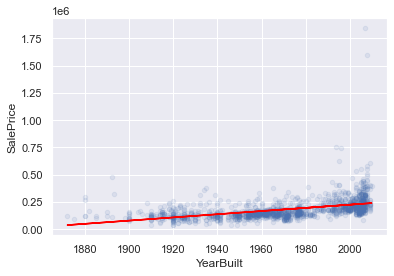

In [194]:
model = sm.OLS(df['SalePrice'], sm.add_constant(df['YearBuilt']))
p = model.fit().params
x = df['YearBuilt']
ax = df.plot(x='YearBuilt', y='SalePrice', kind='scatter', alpha = 0.1)
ax.plot(x, p.const + p['YearBuilt'] * x, c='red')
print(p.const)
print ("correlation :",scipy.stats.pearsonr(df['SalePrice'], df['YearBuilt']))

### Figure 9.4 - Quadratic regression of SalePrice and YearBuilt

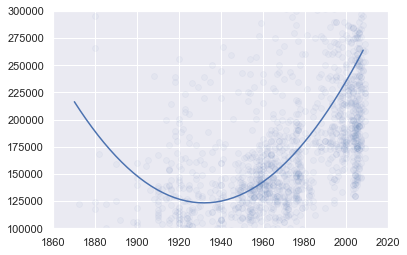

In [195]:
model = np.poly1d(np.polyfit(df['YearBuilt'], df['SalePrice'], 2))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1870, 2008, 50)
plt.scatter(df['YearBuilt'], df['SalePrice'], alpha=.04)
plt.plot(polyline, model(polyline))
plt.xlim(1860,2020)
plt.ylim(100000,300000)
plt.show()

### Figure 9.5 - Quadratic regression of YearBuilt and TotalSF

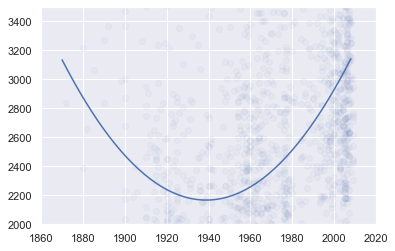

In [196]:
model = np.poly1d(np.polyfit(df['YearBuilt'], df['TotalSF'], 2))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1870, 2008, 50)
plt.scatter(df['YearBuilt'], df['TotalSF'], alpha=.04)
plt.plot(polyline, model(polyline))
plt.xlim(1860,2020)
plt.ylim(2000,3500)
plt.show()

### Figure 9.6 - Quadratic regression of TotalSF And SalePrice

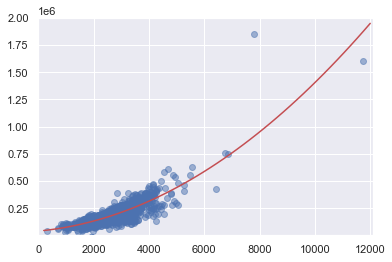

In [197]:
model = np.poly1d(np.polyfit(df['TotalSF'], df['SalePrice'], 2))

#add fitted polynomial line to scatterplot
polyline = np.linspace(200, 12000, 50)
plt.scatter(df['TotalSF'], df['SalePrice'], alpha=.5)
plt.plot(polyline, model(polyline), c='r')
plt.xlim(0,12100)
plt.ylim(2000,2000000)
plt.plot(x, .76 * x)
plt.show()

In [198]:
neighborhood_df = df.drop(columns=['Id','MSSubClass']).groupby('Neighborhood').mean()

scaled_neighborhood = scale(neighborhood_df.select_dtypes(['int64','float64']))
scaled_neighborhood_df = pd.DataFrame(scaled_neighborhood, columns=[neighborhood_df.select_dtypes(['int64','float64']).columns])
scaled_neighborhood_df_x = scaled_neighborhood_df
scaled_neighborhood_df_x.head()

,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,TotalSF,HasPool,YearBuilt
0,0.961016,-0.494713,0.998632,-0.324354,1.091933,0.149619,0.329472,-0.454536,1.256703
1,-0.178874,-0.912913,-1.474674,-0.435877,0.410951,-0.738518,-0.976659,-0.454536,0.275525
2,-0.481658,1.908490,-1.671644,-1.220391,-1.277317,-1.249475,-1.526990,-0.454536,-0.057396
3,-1.097665,-0.845061,-1.017040,-1.031962,-1.185835,-0.934594,-1.105966,-0.454536,-1.612895
4,-0.282686,-0.137103,0.645060,0.808984,-0.071411,0.423542,0.773094,-0.454536,-0.246594


### Figure 10.1

(25, 9)

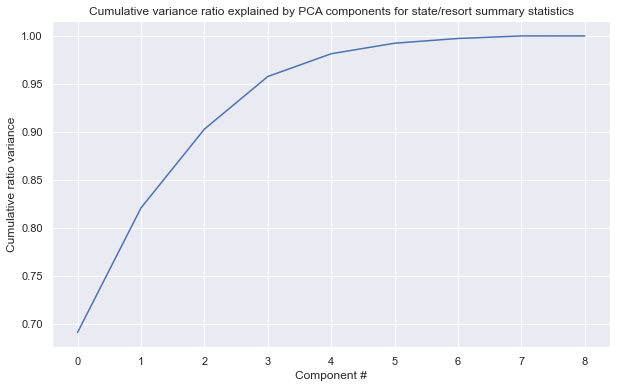

In [199]:
neighborhood_pca = PCA().fit(scaled_neighborhood_df)
plt.subplots(figsize=(10, 6))
plt.plot(neighborhood_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');
neighborhood_pca_x = neighborhood_pca.transform(scaled_neighborhood)
neighborhood_pca_x.shape

### Figure 10.2

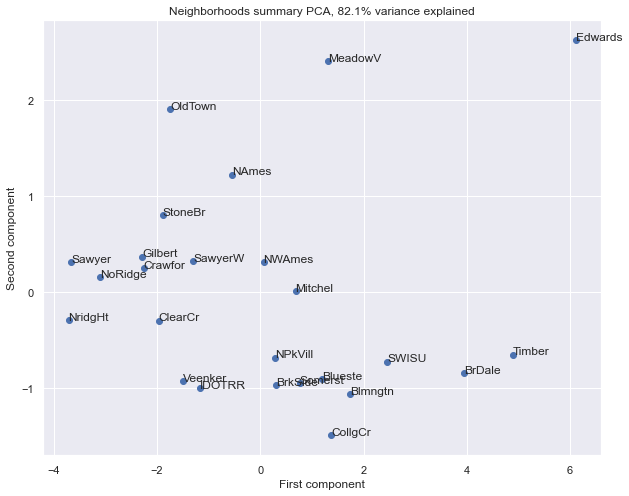

In [200]:
x = neighborhood_pca_x[:, 0]
y = neighborhood_pca_x[:, 1]
neighborhood = df['Neighborhood'].unique()
pc_var = 100 * neighborhood_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Neighborhoods summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(neighborhood, x, y):
    plt.annotate(s, (x, y))

In [201]:
print(df.groupby('Neighborhood').mean())
print(df[df['Neighborhood'] == 'Edwards'].mean())
print(orig_df[orig_df['Neighborhood'] == 'Edwards'].mean())

                      Id  MSSubClass  OverallQual  MasVnrArea  TotalBsmtSF  \
Neighborhood                                                                 
Blmngtn       773.941176  114.117647     7.176471   45.588235  1324.411765   
Blueste       778.500000  160.000000     6.000000    0.000000   638.500000   
BrDale        719.187500  160.000000     5.687500  307.562500   583.875000   
BrkSide       734.724138   49.741379     5.051724    7.396552   765.413793   
ClearCr       604.928571   52.500000     5.892857   84.571429  1226.357143   
CollgCr       726.840000   43.300000     6.640000   97.226667  1157.586667   
Crawfor       801.078431   58.235294     6.274510   81.117647  1032.901961   
Edwards       762.930000   56.800000     5.080000   50.470000   899.820000   
Gilbert       749.151899   58.227848     6.556962   41.518987   869.025316   
IDOTRR        597.540541   53.648649     4.756757   16.216216   746.837838   
MeadowV       733.000000  163.529412     4.470588    4.705882   

/var/folders/qp/hgh__lqs1dz1wk35m_9mqmn40000gn/T/ipykernel_88274/1965535549.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df[df['Neighborhood'] == 'Edwards'].mean())
/var/folders/qp/hgh__lqs1dz1wk35m_9mqmn40000gn/T/ipykernel_88274/1965535549.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(orig_df[orig_df['Neighborhood'] == 'Edwards'].mean())


In [202]:
# I notice that Edwards neighborhood is again an outlier, and I want to understand why. I will examine this
# further by replacing the updated values with the original values, and then running the above on the 
# original sale price column.

neighborhood_df = df.drop(columns=['Id','MSSubClass'])
neighborhood_df['SalePrice'] = orig_df['SalePrice']
neighborhood_df = neighborhood_df.groupby('Neighborhood').mean()
print(neighborhood_df.iloc[7])
scaled_neighborhood = scale(neighborhood_df.select_dtypes(['int64','float64']))
scaled_neighborhood_df = pd.DataFrame(scaled_neighborhood, columns=[neighborhood_df.select_dtypes(['int64','float64']).columns])
scaled_neighborhood_df_x = scaled_neighborhood_df
scaled_neighborhood_df_x.head()

OverallQual         5.08
MasVnrArea         50.47
TotalBsmtSF       899.82
GrLivArea        1340.04
GarageCars          1.18
SalePrice      128219.70
TotalSF          2239.86
HasPool             0.02
YearBuilt        1955.97
Name: Edwards, dtype: float64


,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,TotalSF,HasPool,YearBuilt
0,0.961016,-0.494713,0.998632,-0.324354,1.091933,0.166817,0.329472,-0.454536,1.256703
1,-0.178874,-0.912913,-1.474674,-0.435877,0.410951,-0.710721,-0.976659,-0.454536,0.275525
2,-0.481658,1.908490,-1.671644,-1.220391,-1.277317,-1.215581,-1.526990,-0.454536,-0.057396
3,-1.097665,-0.845061,-1.017040,-1.031962,-1.185835,-0.904458,-1.105966,-0.454536,-1.612895
4,-0.282686,-0.137103,0.645060,0.808984,-0.071411,0.437471,0.773094,-0.454536,-0.246594


### Figure 10.3

(25, 9)

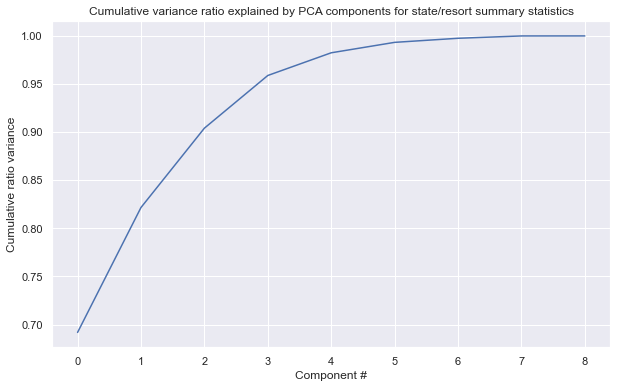

In [203]:
neighborhood_pca = PCA().fit(scaled_neighborhood_df)
plt.subplots(figsize=(10, 6))
plt.plot(neighborhood_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');
neighborhood_pca_x = neighborhood_pca.transform(scaled_neighborhood)
neighborhood_pca_x.shape

### Figure 10.4

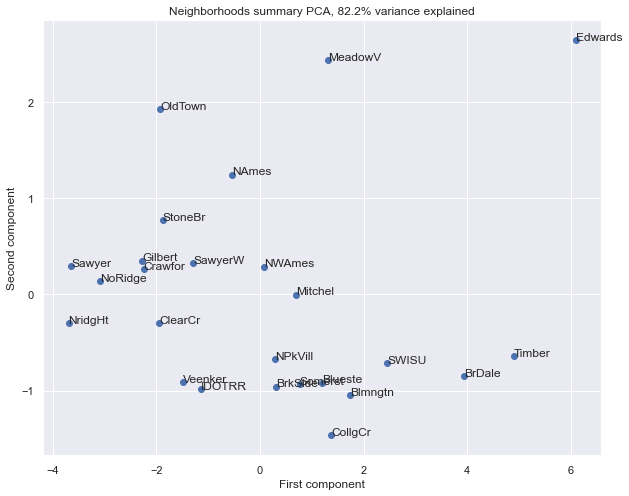

In [204]:
x = neighborhood_pca_x[:, 0]
y = neighborhood_pca_x[:, 1]
neighborhood = df['Neighborhood'].unique()
pc_var = 100 * neighborhood_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Neighborhoods summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(neighborhood, x, y):
    plt.annotate(s, (x, y))

In [205]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
sub_class_df = df.drop(columns=['Id']).groupby('MSSubClass').mean()

scaled_sub_class = scale(sub_class_df.select_dtypes(['int64','float64']))
scaled_sub_class_df = pd.DataFrame(scaled_sub_class, columns=[sub_class_df.select_dtypes(['int64','float64']).columns])
scaled_sub_class_df_x = scaled_sub_class_df
scaled_sub_class_df_x.head()

,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,TotalSF,HasPool,YearBuilt
0,1.699161,0.787949,2.108390,-0.231424,1.409555,1.154773,0.670378,-0.423384,1.468436
1,0.517206,1.701692,-1.195150,-0.117097,0.328508,-0.403500,-0.529752,-0.423384,1.055022
2,-1.476625,-0.624772,-1.763564,-1.523697,-1.659878,-1.315099,-1.965517,-0.423384,0.841308
3,-1.002782,-0.761860,-0.364218,0.416377,-0.938390,-0.630076,0.212929,-0.423384,-1.023607
4,0.375990,0.650409,1.920693,-0.163570,0.836725,0.764669,0.655952,-0.314565,0.727259


### Figure 11.1

(15, 9)

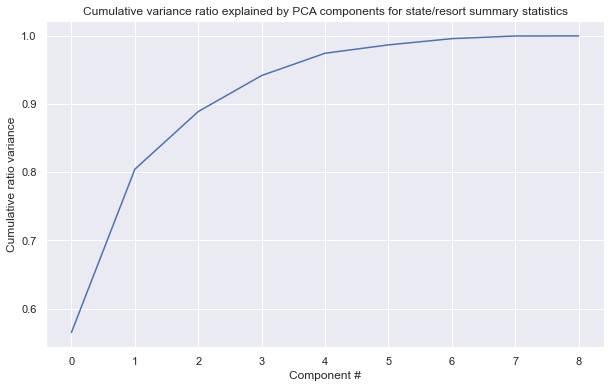

In [206]:
sub_class_pca = PCA().fit(scaled_sub_class_df)
plt.subplots(figsize=(10, 6))
plt.plot(sub_class_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');
sub_class_pca_x = sub_class_pca.transform(scaled_sub_class)
sub_class_pca_x.shape

Figure 11.2

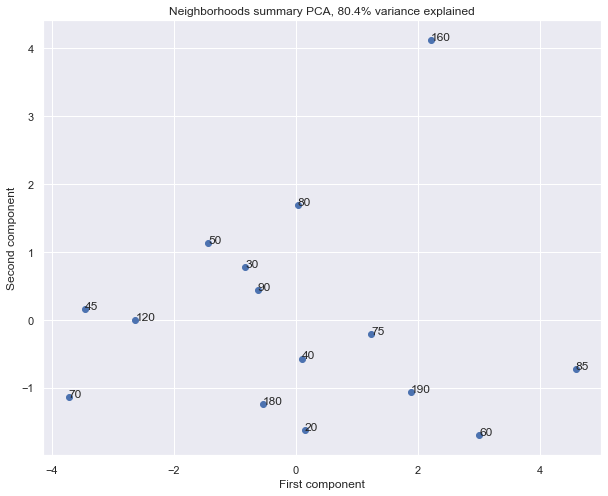

In [207]:
x = sub_class_pca_x[:, 0]
y = sub_class_pca_x[:, 1]
sub_class = df['MSSubClass'].unique()
pc_var = 100 * sub_class_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Neighborhoods summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(sub_class, x, y):
    plt.annotate(s, (x, y))

In [208]:
# We see above that 160, which is newer 2-story homes and split foyer homes, 85, are possibly outliers.
# An obvious connection here is to area, which will be greater for 2-story homes. 

### Figure 12.1

In [209]:
corr = df.select_dtypes(['int64','float64']).drop(columns=['Id']).corr()
corr.style.background_gradient(cmap='coolwarm')

,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,TotalSF,YearBuilt
OverallQual,1.000000,0.407252,0.537808,0.593007,0.609512,0.702909,0.668155,0.572323
MasVnrArea,0.407252,1.000000,0.360067,0.388052,0.364827,0.464459,0.444454,0.311600
TotalBsmtSF,0.537808,0.360067,1.000000,0.454868,0.437908,0.669013,0.826742,0.391452
GrLivArea,0.593007,0.388052,0.454868,1.000000,0.469594,0.723989,0.874373,0.199010
GarageCars,0.609512,0.364827,0.437908,0.469594,1.000000,0.547258,0.539715,0.546073
SalePrice,0.702909,0.464459,0.669013,0.723989,0.547258,1.000000,0.821549,0.450210
TotalSF,0.668155,0.444454,0.826742,0.874373,0.539715,0.821549,1.000000,0.347133
YearBuilt,0.572323,0.311600,0.391452,0.199010,0.546073,0.450210,0.347133,1.000000


In [210]:
# I'm going to drop MasVnrArea as well now. Unlike year built, this isn't the 
# type of value that would be parabolic.
df.drop(columns=['MasVnrArea'], inplace = True)

In [211]:
corr = df.select_dtypes(['int64','float64']).drop(columns=['Id']).corr()
corr.style.background_gradient(cmap='coolwarm')

,OverallQual,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,TotalSF,YearBuilt
OverallQual,1.000000,0.537808,0.593007,0.609512,0.702909,0.668155,0.572323
TotalBsmtSF,0.537808,1.000000,0.454868,0.437908,0.669013,0.826742,0.391452
GrLivArea,0.593007,0.454868,1.000000,0.469594,0.723989,0.874373,0.199010
GarageCars,0.609512,0.437908,0.469594,1.000000,0.547258,0.539715,0.546073
SalePrice,0.702909,0.669013,0.723989,0.547258,1.000000,0.821549,0.450210
TotalSF,0.668155,0.826742,0.874373,0.539715,0.821549,1.000000,0.347133
YearBuilt,0.572323,0.391452,0.199010,0.546073,0.450210,0.347133,1.000000


** Figure 12.2 - Heatmap Correlation between numerical features shows correlations between .4 and .8 for the target variable. **

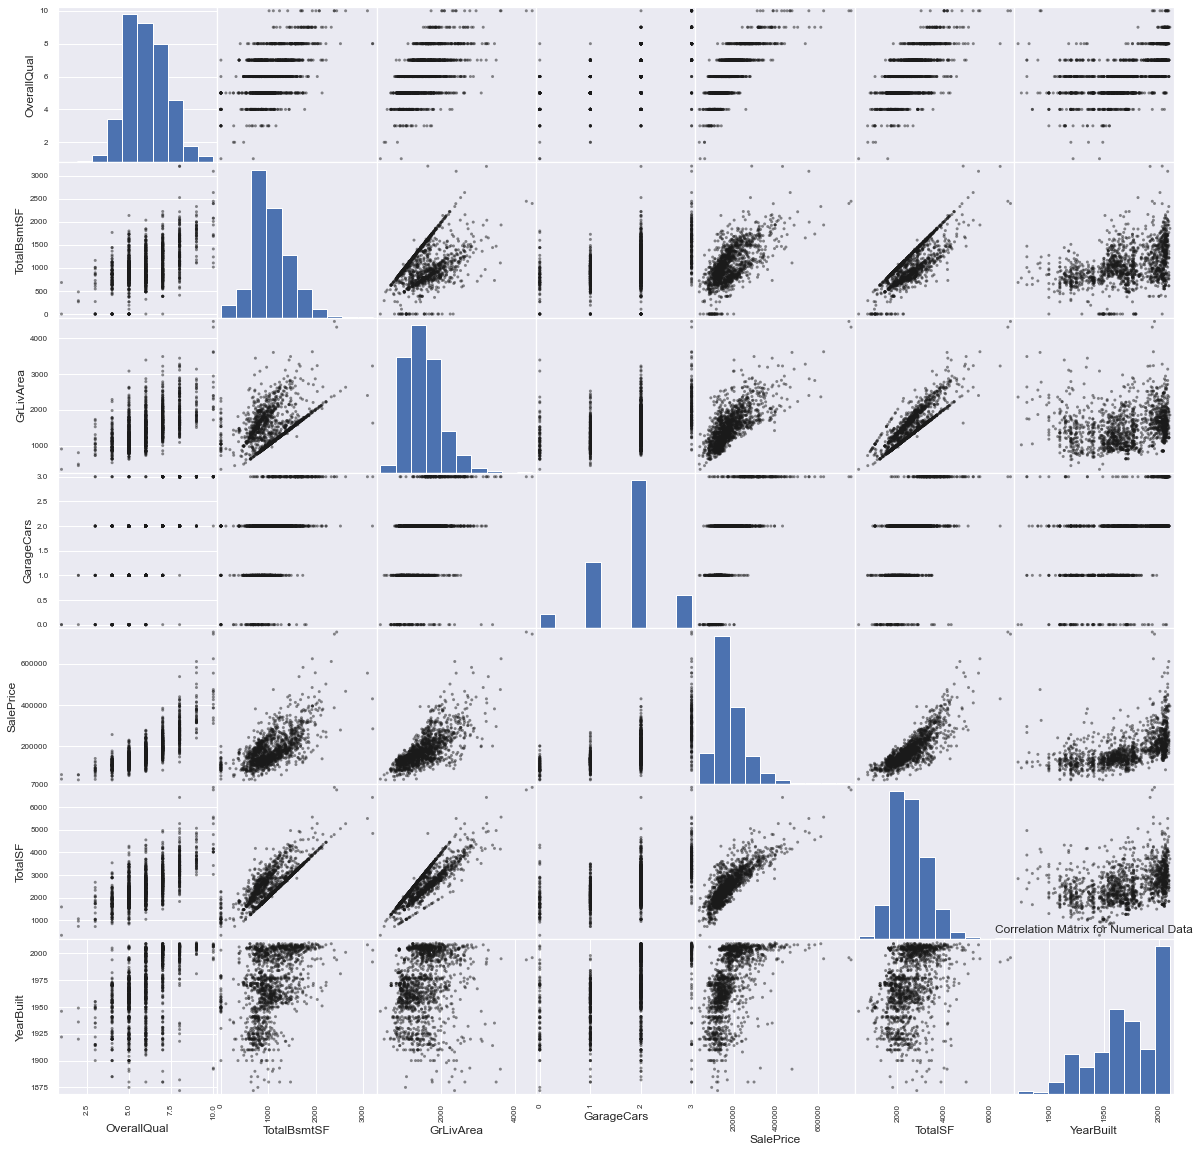

In [213]:
data = df[df['SalePrice'] < 1000000].select_dtypes(['int64','float64']).drop(columns=['Id'])
pd.plotting.scatter_matrix(data,figsize=(20,20), c='k')
plt.title('Correlation Matrix for Numerical Data')
plt.show()

## Multivariate Analysis

In [272]:
def plotdata():
    df.plot.scatter('TotalSF','SalePrice')

In [288]:
def plotfit(fit,title):
    plotdata()
    plt.title(title)
    plt.scatter(df.TotalSF,fit.predict(df),c='r',alpha=.5)
    plt.show()

### Compare TotalSF to SalePrice with GarageCars grouped by OverallQual

In [289]:
model1 = smf.ols(formula = 'SalePrice ~ 1 + GarageCars:OverallQual', data=df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


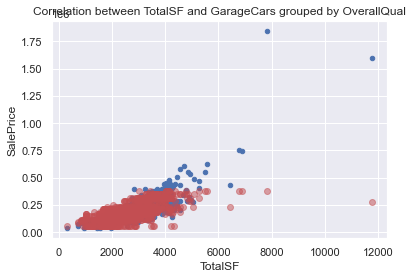

In [290]:
model1=model1.fit()
plotfit(model1, 'Correlation between TotalSF and GarageCars grouped by OverallQual')

In [291]:
model1.params

Intercept                 61151.061626
GarageCars:OverallQual    10711.233586
dtype: float64

### Compare TotalSF to SalePrice with Total grouped by OverallQual

In [292]:
model2 = smf.ols(formula = 'SalePrice ~ 1 + GrLivArea:OverallQual', data=df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


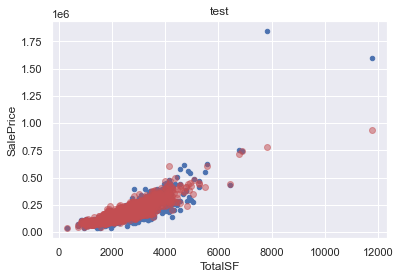

In [293]:
model2 = model2.fit()
plotfit(model2,'test')

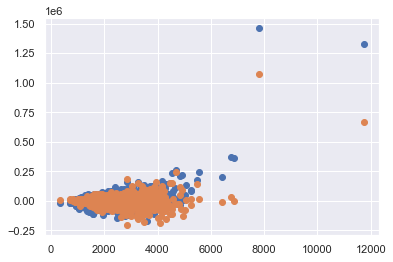

In [294]:
plt.scatter(df.TotalSF,model1.resid)
plt.scatter(df.TotalSF,model2.resid)

In [305]:
print('Mean Square Error : ',(model1.mse_resid, model2.mse_resid))

Mean Square Error :  (4814628569.742498, 2679028111.5646596)


In [308]:
print('r-squared : ',(model1.rsquared, model2.rsquared))

r-squared :  (0.49830896984164263, 0.7208415241913548)


In [297]:
sm.stats.anova_lm(model1)

,df,sum_sq,mean_sq,F,PR(>F)
GarageCars:OverallQual,1.0,6.972406e+12,6.972406e+12,1448.171154,1.227517e-220
Residual,1458.0,7.019728e+12,4.814629e+09,NaN,NaN


In [298]:
sm.stats.anova_lm(model2)

,df,sum_sq,mean_sq,F,PR(>F)
GrLivArea:OverallQual,1.0,1.008611e+13,1.008611e+13,3764.839807,0.0
Residual,1458.0,3.906023e+12,2.679028e+09,NaN,NaN


*As expected, the Goodness of Fit in model2 is greater than that of model1, because the explanatory variable GarageCars, while strongly correlated, is a discrete variable. Similarly, the ANOVA shows results that we would expect. Both are statistically significant, but model2 is moreso.*

In [58]:
datapath = '../data'
save_file(df, 'house_refined_data_cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/house_refined_data_cleaned.csv"
